In [48]:
# writing code in the notebook is different then writung the code in the vs code.

!pip install -qU langgraph langchain_groq

In [49]:
import getpass
import os

def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
        
set_env("GROQ_API_KEY")

In [50]:
os.environ["GROQ_API_KEY"] = getpass.getpass("enter the key:")

enter the key: ········


In [5]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [94]:
@tool

def get_weather(location: str):
    """call to get the current weather"""
    if location.lower() in [ "sf", "san francisco"]:
        return "it's 60 degrees and foogy."
    else : 
        return "it's 90 degree and sunny."
    
    
@tool
def get_coolest_cities():
    """Get a list of the coolest cities"""
    return "nyc"
    

In [95]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [23]:
#TOOLNODE IS used to make the things run when multiple tools are called for the work.

# ToolNode opperate on graph state with a list of messages, it expect that last message to
# be the AIMessage with tool_calls parameter 

In [26]:
# message_with_single_tool_call = AIMessage(
#     content =  "",
#     tool_call = [
#     {
#         "name" : "get_weather", 
#         "args" : {"location " , "sf"}, 
#         "id" : "tool_call_id",
#         "type" : "tool_call", 
        
#     }],
# )


# tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': []}

In [83]:
# message_with_single_tool_call = AIMessage(
#     content="",
#     tool_calls=[
#         {
#             "name": "get_weather",
#             "args": {"location": "sf"},
#             "id": "tool_call_id",
#             "type": "tool_call",
#         }
#     ],
# )

# tool_node.invoke({"messages": [message_with_single_tool_call]})

In [28]:
# here we are generating the answers but we have not to do it the langchain model will be doing that support tool calling

In [96]:
message_with_multiple_tool_calls = AIMessage(
    content = "", 
    tool_calls = [
        
        {
             "name": "get_coolest_cities",
            "args": {}, # we have not provided anything that's why the content will be return is 
            #nyc and sf
            "id": "tool_call_id_1",
            "type": "tool_call",
            
        }, 
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
        
    ],

)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="it's 60 degrees and foogy.", name='get_weather', tool_call_id='tool_call_id_2')]}

In [97]:
#using the chat model:

from typing import Literal

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

model_with_tools = ChatGroq(
    model="mixtral-8x7b-32768", temperature=0
).bind_tools(tools) # bind_tools will be used to the ensure that the model is aware of the available tools

In [98]:
model_with_tools.invoke("what is the weather in sf? " ).tool_calls

[{'name': 'get_weather',
  'args': {'location': 'sf'},
  'id': 'call_reyd',
  'type': 'tool_call'}]

In [99]:
tool_node.invoke({"messages": [model_with_tools.invoke("what is the weather in sf?")]})

{'messages': [ToolMessage(content="it's 60 degrees and foogy.", name='get_weather', tool_call_id='call_srpf')]}

In [100]:
# ReAct Agent: This agent take some query and then repeatedly call the agent untill the
# the tools has enough information to solve the query.


In [101]:
from typing import Literal # to save the  base data for your software

from langgraph.graph import StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# here i am calling the function "should_continue" and the parameter is the state which is 
# MessageState which i am saying store the tools and the end value.
# messages name  include the value of the state["messages"] and the last message is given to the last one
# and if the last message  one calls  it incluede the tools or end the graph


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}
    
# we define that the message will be store in the response

# workflow refers to the as we see in the llm the single prompt manage every intent, 
# so the better is that as it was difficult to create the predictably great user experiences 
# for known intents with this approach.

#workflow can focus on its domain, allowing for isolated improvements without degrading the overall assistant

# tools have all the info of the tools.

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,

)

workflow.add_edge("tools", "agent")

app = workflow.compile()




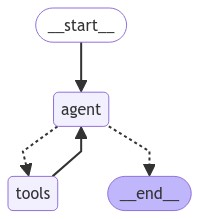

In [102]:
from IPython.display import Image, display

try: 
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [103]:
for chunk in app.stream(
    {
        "messages": [("human", "what is the weather in the sf?")]}, stream_mode = "values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in the sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_esdw)
 Call ID: call_esdw
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

it's 60 degrees and foogy.
================================== Ai Message ==================================

It's 60 degrees and foggy in San Francisco.


In [104]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_bn70)
 Call ID: call_bn70
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_d1rj)
 Call ID: call_d1rj
  Args:
    location: nyc
================================= Tool Message =================================
Name: get_weather

it's 90 degree and sunny.
================================== Ai Message ==================================

It's 90 degrees and sunny in NYC, one of the coolest cities.
